<a href="https://colab.research.google.com/github/yolandaazzahra/TaskWeek6/blob/main/TaskWeek6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Yolanda Azzahra

NPM : 2306319514

Original Code : https://www.kaggle.com/code/youssefabdelghfar/twitter-sentiment-analysis-nlp-lstm

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'twitter-entity-sentiment-analysis:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1520310%2F2510329%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241008%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241008T114227Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D67100b0676f1fe99ad985454f027da2eddf0321607a18e0081e883d5cc182a6700b5e9ab84ec1603ffb02b2f7800aa2138694d028aa18731e88ff690552d7c3fab13e5a1a5d7b01e97fdda7296f3be2cb1e59731c8a3e074ef5d465a04f2f60f095a4c50df5df2b3c228fe2114a3c717a83fe08bc199fa501ba61612c0af4964bdb8d9a9334f9a9cbf910af6effb98700dc8ca9ce4d97e9e07e42f2e93aeff0f57a15e1f3046ae79a69900561a81bff1853fa7122c8873eba4b4e6847fd5d9ffd7704770050ec6638a7a82853dc4d99fd4f8c54c9ecafef3341f1c4e82667ba80791b1eb2cea19b3d9aef836c3d72e6007534115fc4dd1ed800759e5ec105510'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2090169 bytes downloaded
Downloaded and uncompressed: twitter-entity-sentiment-analysis
Data source import complete.


# Import Necessary Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
import spacy


# Reading The Data

In [3]:
df_train = pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
df_test = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv")

# Explore The Data

**Train Data**

In [4]:
df_train.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


**Test Data**

In [5]:
df_test.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


**We can see no header in data then i will add header**

In [6]:
df_test.columns = ['Header1', 'company','labels','text']
df_train.columns = ['Header1', 'company','labels','text']

In [7]:
df_train.head()

,Header1,company,labels,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [8]:
df_test.head()

,Header1,company,labels,text
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [9]:
df_train.shape

(74681, 4)

In [10]:
df_test.shape

(999, 4)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Header1  74681 non-null  int64 
 1   company  74681 non-null  object
 2   labels   74681 non-null  object
 3   text     73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Header1  999 non-null    int64 
 1   company  999 non-null    object
 2   labels   999 non-null    object
 3   text     999 non-null    object
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


In [13]:
df_train.duplicated().sum()

2700

In [14]:
df_test.duplicated().sum()

0

In [15]:
df_train.isnull().sum()

,0
Header1,0
company,0
labels,0
text,686


In [16]:
df_test.isnull().sum()

,0
Header1,0
company,0
labels,0
text,0


# Cleaning the Data

In [17]:
df_train.dropna(inplace=True)

In [18]:
df_train.isnull().sum()

,0
Header1,0
company,0
labels,0
text,0


In [19]:
df_train.drop_duplicates(inplace=True)

In [20]:
df_train.duplicated().sum()

0

**Drop Uneeded Columns**

In [21]:
df_train.drop(columns=['Header1', 'company'], inplace=True)

In [22]:
df_test.drop(columns=['Header1', 'company'], inplace=True)

In [23]:
df_train

,labels,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
74676,Positive,Just realized that the Windows partition of my...
74677,Positive,Just realized that my Mac window partition is ...
74678,Positive,Just realized the windows partition of my Mac ...
74679,Positive,Just realized between the windows partition of...


In [24]:
df_test

,labels,text
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


# Preprocessing the Data

In [25]:
def clean_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove special characters, numbers, and punctuations
    tweet = re.sub(r'\W', ' ', tweet)
    tweet = re.sub(r'\d', ' ', tweet)
    tweet = re.sub(r'\s+', ' ', tweet)
    tweet = tweet.strip()
    return tweet

In [26]:
# Clean the training data
df_train['text'] = df_train['text'].apply(clean_tweet)

# Clean the test data
df_test['text'] = df_test['text'].apply(clean_tweet)

In [27]:
df_train.head()

,labels,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you all
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands and i will murder yo...
4,Positive,im getting into borderlands and i can murder y...


In [28]:
df_test.head()

,labels,text
0,Neutral,BBC News Amazon boss Jeff Bezos rejects claims...
1,Negative,Why do I pay for WORD when it functions so poo...
2,Negative,CSGO matchmaking is so full of closet hacking ...
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi I ve had Madeleine McCann in my cellar for ...


In [29]:
df_train['text'] = df_train['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

In [30]:
# Drop rows where 'OriginalTweet' is empty
df_train = df_train.dropna(subset=['text'])
df_test = df_test.dropna(subset=['text'])

# Alternatively, if there are rows with just whitespace, use this to remove them as well:
df_train = df_train[df_train['text'].str.strip() != '']
df_test = df_test[df_test['text'].str.strip() != '']

# Display the updated dataframe
df_train.head()

,labels,text
0,Positive,i am coming to the borders and i will kill you...
1,Positive,im getting on borderlands and i will kill you all
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands and i will murder yo...
4,Positive,im getting into borderlands and i can murder y...


In [31]:
df_train.duplicated().sum()

4661

In [32]:
df_train = df_train.drop_duplicates(subset=['text'])

In [33]:
df_train.shape

(66387, 2)

# Split the Data

In [34]:
# Separate features and labels for training data
train_texts = df_train['text'].values
train_labels = df_train['labels'].values

# Separate features and labels for test data
test_texts = df_test['text'].values
test_labels = df_test['labels'].values

In [35]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

In [36]:
# Initialize the tokenizer
tokenizer = Tokenizer()  # You can adjust the number of words

# Fit the tokenizer on the training texts
tokenizer.fit_on_texts(train_texts)
tokenizer.fit_on_texts(test_texts)

In [37]:
# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [38]:
# Maximum Length in X_train_sequences
maxlen = max(len(tokens) for tokens in train_sequences)
print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 166


In [39]:
train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post')

In [40]:
# Embedding Input Size
input_size = np.max(train_padded) + 1
input_size

29385

# Building the Model

In [41]:
# Define the model
model = Sequential()

# Add an embedding layer
model.add(Embedding(input_dim=input_size, output_dim=100, input_shape=(56,)))

# Add a bidirectional LSTM layer with 128 units
model.add(Bidirectional(LSTM(128, kernel_regularizer=l2(0.1), return_sequences=True, recurrent_regularizer=l2(0.1))))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add another LSTM layer
model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
# Add batch normalization layer
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Add a dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

# Add dropout regularization
model.add(Dropout(0.5))

# Add the output layer with 5 units for 5 labels and softmax activation
model.add(Dense(5, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [42]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 56, 100)             │       2,938,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 56, 256)             │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 56, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 56, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,347,465 (12.77 MB)

 Trainable params: 3,346,697 (12.77 MB)

 Non-trainable params: 768 (3.00 KB)

In [43]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [44]:
history = model.fit(
    train_padded,
    train_labels_encoded ,
    validation_data=(test_padded,test_labels_encoded),
    epochs=10
)

Epoch 1/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 87s 36ms/step - accuracy: 0.4492 - loss: 8.5251 - val_accuracy: 0.8068 - val_loss: 0.6790
Epoch 2/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 70s 33ms/step - accuracy: 0.7895 - loss: 0.7085 - val_accuracy: 0.8919 - val_loss: 0.4343
Epoch 3/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 71s 34ms/step - accuracy: 0.8397 - loss: 0.5629 - val_accuracy: 0.7087 - val_loss: 0.9822
Epoch 4/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 80s 33ms/step - accuracy: 0.8665 - loss: 0.4964 - val_accuracy: 0.8869 - val_loss: 0.4469
Epoch 5/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.8837 - loss: 0.4400 - val_accuracy: 0.8729 - val_loss: 0.4488
Epoch 6/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.8944 - loss: 0.4041 - val_accuracy: 0.9129 - val_loss: 0.3951
Epoch 7/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 70s 34ms/step - accuracy: 0.9051 - loss: 0.3701 - val_accuracy: 0.7528 - val_loss: 1.0293
Epoch 8/10
2075/2075 ━━━━━━━━━━━━━━━━━━━━ 82s 34ms/step - accuracy: 0.9131 -

# Evaluate the model

In [45]:
test_loss, test_accuracy = model.evaluate(test_padded , test_labels_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9083 - loss: 0.3452
Test Loss: 0.34763303399086
Test Accuracy: 0.9179179072380066


# Visualize training history

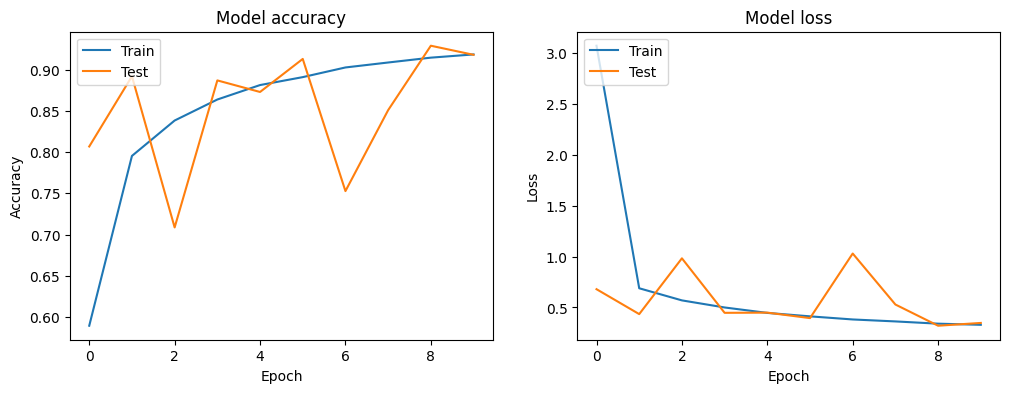

In [46]:


# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()